In [12]:
%matplotlib inline
import stock_analysis
import itertools
import pandas as pd
from stock_analysis.utils import group_stocks
from stock_analysis.utils import make_portfolio
from matplotlib.ticker import StrMethodFormatter
from pandas.plotting import autocorrelation_plot
from stock_analysis import StockModeler

start, end = '2019-01-01', '2020-12-31'
reader = stock_analysis.StockReader(start, end)

bitcoin = reader.get_bitcoin_data('USD')

fb, aapl, amzn, nflx, goog = (reader.get_ticker_data(ticker)for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG'])

sp = reader.get_index_data('S&P 500')

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

# project1
Рассчет и простроение трех уровней поддержки и сопротивления для цен закрытия Нетфликса в период с 2019-01 по 2021-01.

Text(0, 0.5, 'Price(.50)')

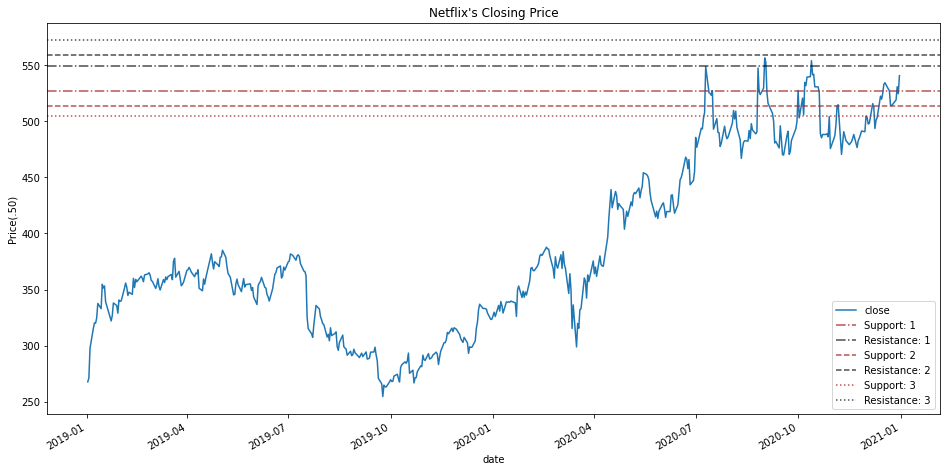

In [15]:
def levels(analyzer, method):
    return [getattr(analyzer, method)(a) for a in range(1, 4)]

netflix = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (
    levels(netflix, metric) for metric in ['support', 'resistance']
)

viz = stock_analysis.StockVisualizer(nflx)
ax = viz.evolution_over_time('close', figsize=(16, 8), title="Netflix's Closing Price")

for support, resistance, line, n in zip(support_levels, resistance_levels, ["dashdot", "dashed", "dotted"], itertools.count(1)):

    viz.add_reference_line(
        ax, 
        y = support, 
        label = f'Support: {n}', 
        color = 'brown',
        linestyle = line,
        alpha = 0.8)

    viz.add_reference_line(
        ax, 
        y=resistance, 
        label=f'Resistance: {n}', 
        color='black',
        linestyle=line,
        alpha = 0.7)
ax.set_ylabel('Price(.50)')

# project2
Влияние торговли в нерабочее время на акции FAANG

1) Как отдельные акции

array([[<AxesSubplot:title={'center':"Amazon Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Amazon after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Apple Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Apple after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Facebook Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Facebook after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Google Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Google after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Netflix Open Price - Prior Day's Close"}, xlabel='da

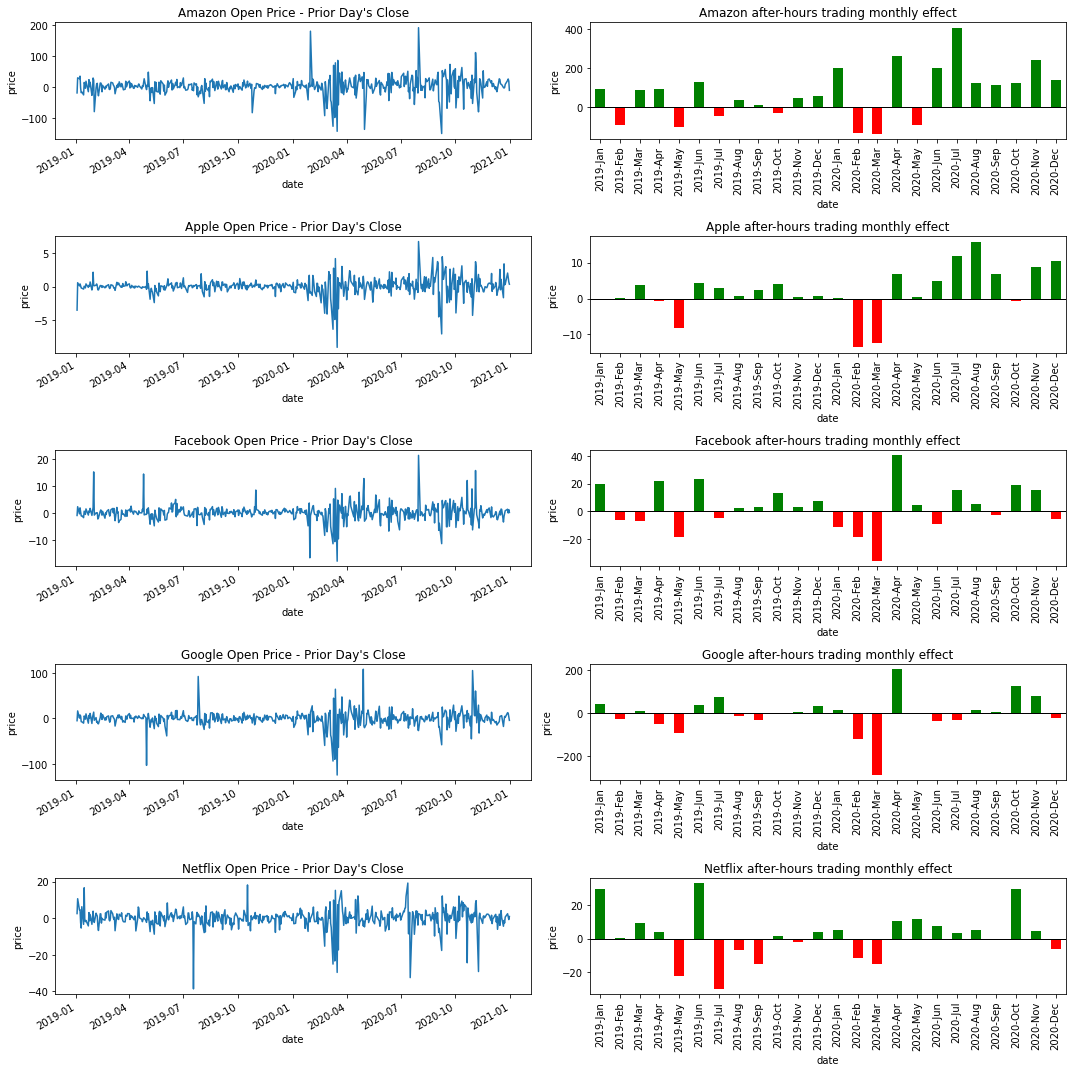

In [16]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

2) Как портфолио

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

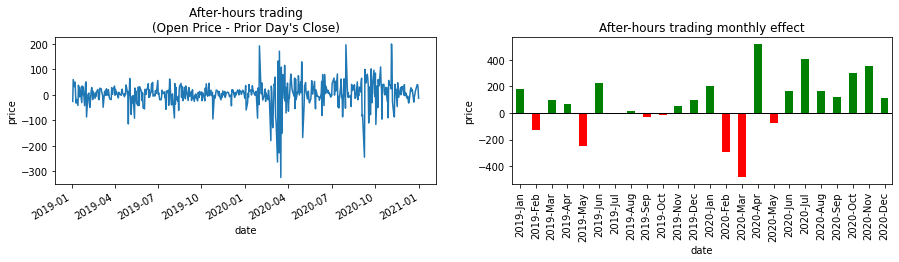

In [17]:
stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()

# project3
График, объединяющий цены открытия и закрытия акций FAANG и визуализирующий их рост и упадок с периодичностью в день.

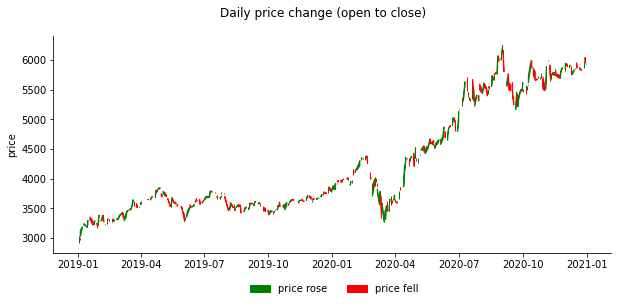

In [6]:
ax = stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()

Визувлизация для Bitcoin и S&P 500

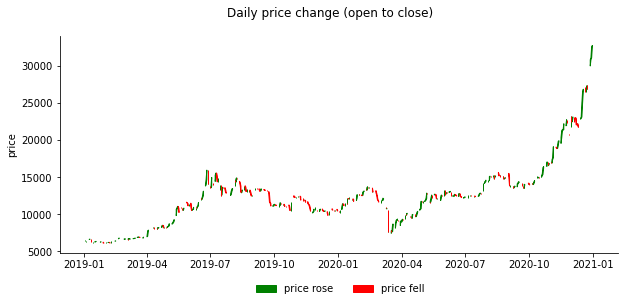

In [7]:
import pandas as pd
import numpy as np

def reindex(df):
    inp = df.copy().reindex(pd.date_range(start, end=end, freq="D")).assign(high = lambda x: x.high.combine_first(x.close),
                                                                low = lambda x: x.low.combine_first(x.close),
                                                                open = lambda x: x.open.combine_first(x.close),
                                                                close = lambda x: x.fillna(method='ffill'),
                                                                volume = lambda x: x.fillna(0)
                                                                )
    inp.index.rename('date', inplace=True)
    return inp

sp_reindexed = reindex(sp)
ax = stock_analysis.StockVisualizer(bitcoin + sp_reindexed).open_to_close()


# project4
Сравнение совместных фондов с тремя самыми высокими ценами на акции.

In [8]:
nvda = reader.get_ticker_data('NVDA')
msft = reader.get_ticker_data('MSFT')
amzn = reader.get_ticker_data('AMZN')
aapl = reader.get_ticker_data('AAPL')
comp = group_stocks({'0 - nVidia': nvda,
                     '1 - Microsoft': msft,
                     '2 - Amazon': amzn,
                     '3 - Apple': aapl})
stock_analysis.AssetGroupAnalyzer(comp).analyze('annualized_volatility')

{'0 - nVidia': 0.5791745322613896,
 '1 - Microsoft': 0.4394683613426673,
 '2 - Amazon': 0.3851099077041784,
 '3 - Apple': 0.4670809643500882}

# project5
Функия, возвращая таблицу данных с одной строкой, содержащей столбцы: alpha, beta, sharpe_ratio, annualized_volatility, is_bear_market, is_bull_market. Каждый столбец содержит соответствующие методы для данной акции.

In [11]:
def df(analys, a_b, ratio):
    return pd.DataFrame({metric: getattr(stock_analysis.StockAnalyzer(analys), metric)(**kwargs)
        for metric, kwargs in {
            'alpha': {'index': a_b, 'r_f': ratio}, 
            'beta': {'index': a_b}, 
            'sharpe_ratio': {'r_f': ratio},
            'annualized_volatility': {},
            'is_bear_market': {},
            'is_bull_market': {}}.items()}, index=range(1))
df(nvda, sp, ratio=reader.get_risk_free_rate_of_return())

,alpha,beta,sharpe_ratio,annualized_volatility,is_bear_market,is_bull_market
0,2.123698,1.438045,2.837924,0.579175,False,False


# project6
Модель Арима, основанная на данных S&P 500 с 2019-01 по 2020-11, построенная для пресказывания производительности за декабрь 2020.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

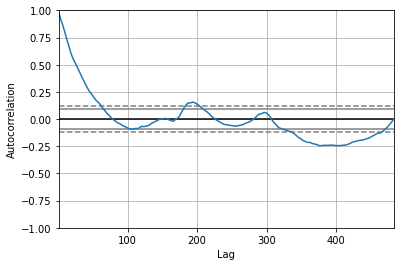

In [3]:
train, test = sp['2019':'2020-11'], sp.loc['2020-12']
autocorrelation_plot(train.close)

In [4]:
%%capture
arima_model = StockModeler.arima(train, ar=10, i=1, ma=5)

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

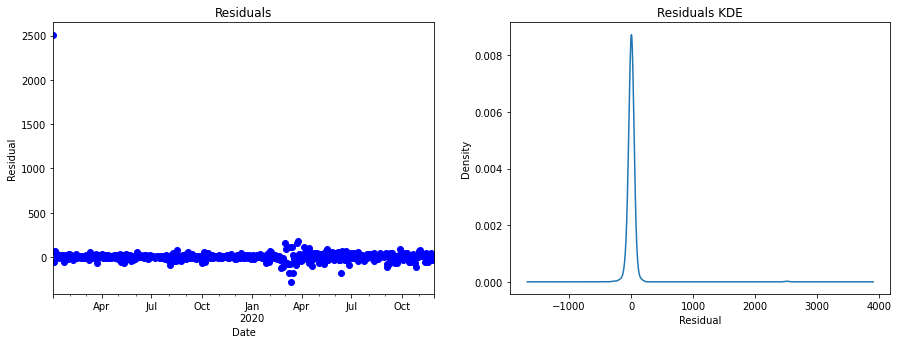

In [5]:
StockModeler.plot_residuals(arima_model)

Text(0, 0.5, 'Price (0.25)')

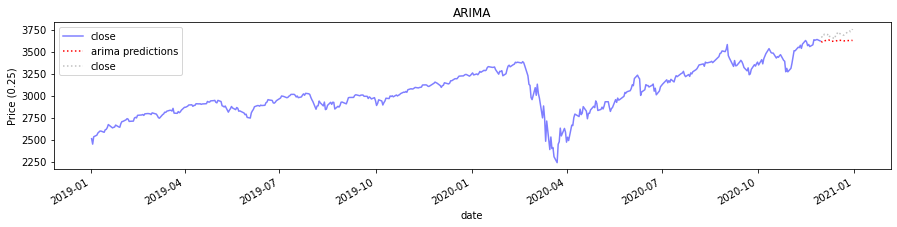

In [6]:
date = test.index
arima_ax = StockModeler.arima_predictions(train, arima_model, start = date[0], end = date[-1], title='ARIMA', color='b', 
                                          figsize=(15, 3), alpha=0.5)
test.close.plot(linestyle = "dotted", color = "grey", alpha=0.5, ax=arima_ax)
arima_ax.legend()
arima_ax.set_ylabel('Price (0.25)')

# project7
Сбор ежедневного курса обмена иностранной валюты с 2019-02 по 2020-01 с интервалом в 1 неделю.
(API ключ взят с сайта https://www.alphavantage.co/support/#api-key)

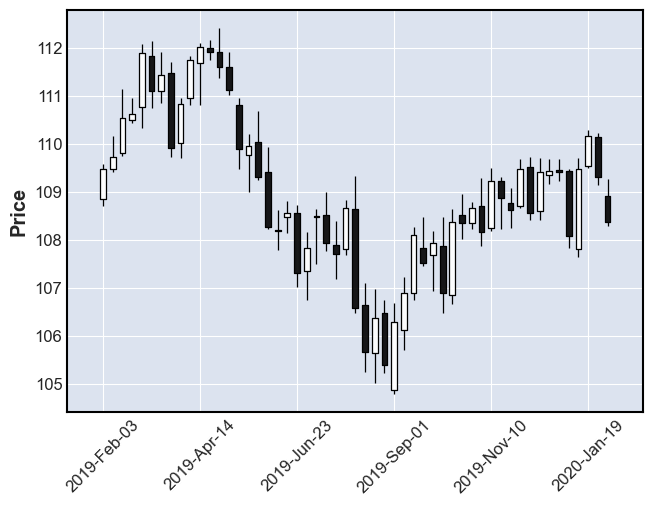

In [7]:
forex = reader.get_forex_rates('USD', 'JPY', api_key='CLEQM49H4V9PVJPE')
stock_analysis.StockVisualizer(forex).candlestick(date_range=slice('2019-02-01', '2020-01-31'), resample='1W')